## 1. Setup and Use An a Pretrained classifier

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub 

In [2]:
!pip install tensorflow-hub

### Download the classifier

Use `hub.KerasLayer` to load a [MobileNetV2 model](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) from TensorFlow Hub. Any [compatible image classifier model](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [3]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" #@param {type:"string"}

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

65536/61306 [================================] - 0s 0us/step


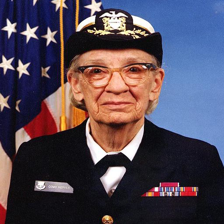

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

Take the predicted class ID and fetch the `ImageNet` labels to decode the predictions

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


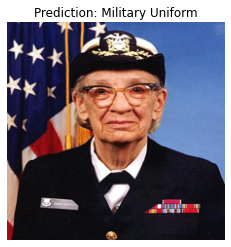

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## 3. Apply transfer learning

But what if you want to train a classifier for a dataset with different classes? You can also use a model from TFHub to train a custom image classier by retraining the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [11]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 3s 0us/step


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

TensorFlow Hub's conventions for image models is to expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [13]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [16]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [17]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'bee', 'ant', 'daisy', 'bee', 'porcupine', 'rapeseed',
       'daisy', 'balloon', 'park bench', 'passenger car', 'hair slide',
       'bottlecap', 'daisy', 'shopping basket', 'daisy', 'daisy',
       'picket fence', 'daisy', 'daisy', 'daisy', 'hummingbird', 'orange',
       'bathing cap', 'plow', 'bee', 'daisy', 'sea urchin', 'buckeye',
       'coral fungus', 'daisy', 'American chameleon'], dtype='<U30')

Now check how these predictions line up with the images:

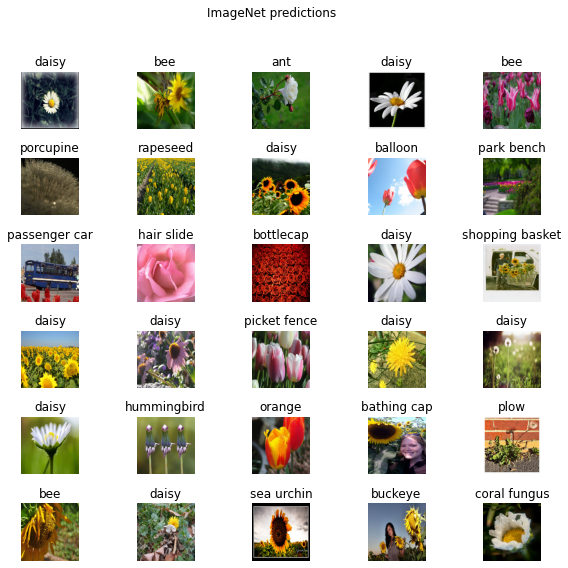

In [18]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [compatible image feature vector model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [19]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [20]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

It returns a 1280-length vector for each image:

In [21]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [22]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([32, 5])

## 4. Train the Model and Visualize Results

Use compile to configure the training process:

### Let's now Train the model

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [26]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [27]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 21s 145ms/step - loss: 0.4087 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 16s 141ms/step - loss: 0.3208 - acc: 0.9062


### Let's now Visualize the Results

Now after, even just a few training iterations, we can already see that the model is making progress on the task.✌

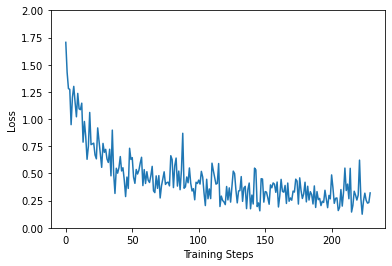

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

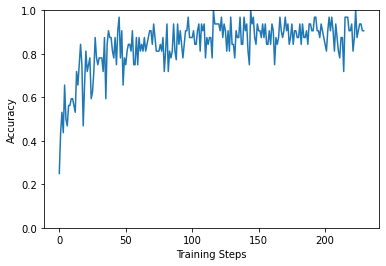

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

## 5. Make Visualized Predictions

To redo the plot from before, first get the ordered list of class names:

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [31]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [32]:
label_id = np.argmax(label_batch, axis=-1)

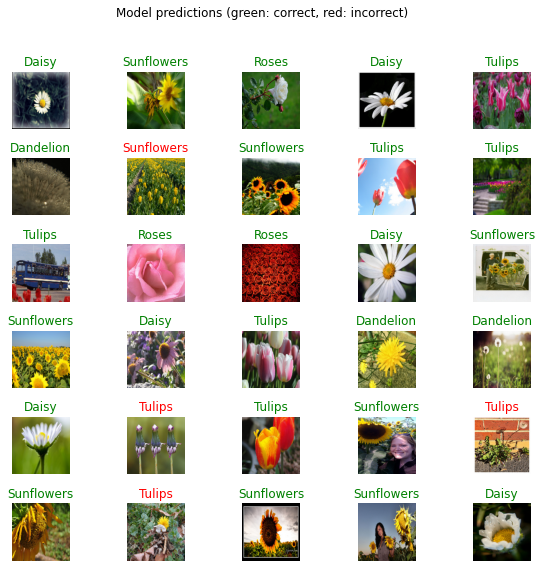

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Extra

Imagine, you have a 28 * 28 image and you run a 3 * 3 convolution neural network on it with the input depth of 3 and output depth of 8.

Note: Stride is 1 and you are using same padding.

What is the dimension of output feature map when you are using the given parameters.🤔

A) 28 width, 28 height and 8 depth

B) 13 width, 13 height and 8 depth

C) 28 width, 13 height and 8 depth

D) 13 width, 28 height and 8 depth

**Solution: (A)**

The formula for calculating output size is output size = (N – F)/S + 1

where, N is input size, F is filter size and S is stride.